In [1]:
! pip3 install dowhy

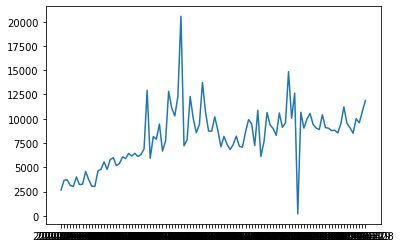

In [4]:
import pandas as pd

#merged = pd.read_csv('../data/merged_transaction_merchandise_09_01_on_variant_id')
merged = pd.read_csv('../data/uniqlo_prod_loy.csv')


from collections import Counter
import matplotlib.pyplot as plt

c = Counter(merged["order_date"])
plt.plot(c.keys(),c.values())
plt.show()

# Estimating the effect of a buying a certain product

> What is the impact on a client habits of buying a certain product ?

In formal language, we are interested in the Average Treatment Effect on the Treated (ATT). 

We chose the variant 435193 as test product because its buy a lot.

In [6]:
from datetime import datetime
tmp = merged[["customer_id","variant_id","order_date"]].copy()
tmp["order_date"] = [datetime.strptime(x,"%Y-%m-%d") for x in tmp["order_date"]]
variant = 435806
variant = 435193
all_cus = {c : d for v,c,d in zip(tmp["variant_id"],tmp["customer_id"],tmp["order_date"]) if v == variant}
count_cus = Counter(tmp["customer_id"])

tmp["treatment"] = [x in all_cus.keys() for x in tmp["customer_id"]]
tmp["buying_date"] = [all_cus.get(x,None) for x in tmp["customer_id"]]
tmp["count_customer"] = [count_cus.get(x,0) for x in tmp["customer_id"]]
#tmp = tmp[tmp["count_customer"]>10]
print(Counter(tmp["treatment"]))

Counter({False: 774316, True: 36827})


In [7]:
mean_purchase = tmp.groupby("customer_id")["order_date"].mean()
first_purchase = tmp.groupby("customer_id")["order_date"].min()
last_purchase = tmp.groupby("customer_id")["order_date"].max()
tmp["first_purchase"] = [first_purchase[x] for x in tmp["customer_id"]]
tmp["last_purchase"] = [last_purchase[x] for x in tmp["customer_id"]]
tmp["buying_date"] = [all_cus.get(x,None) if x in all_cus.keys() else mean_purchase[x].date() for x in tmp["customer_id"]]
tmp["mean_purchase"] = [mean_purchase[x].date() for x in tmp["customer_id"]]
tmp

,customer_id,variant_id,order_date,treatment,buying_date,count_customer,first_purchase,last_purchase,mean_purchase
0,US621111116245019,435193,2021-09-20,True,2021-09-20,3,2021-08-18,2021-09-20,2021-09-09
1,US051401091310415435,435193,2021-09-20,True,2021-05-29,25,2021-05-07,2021-09-20,2021-05-30
2,US621111115993715,435193,2021-09-20,True,2021-04-20,4,2021-04-20,2021-09-20,2021-05-28
3,US621111114664880,435193,2021-09-20,True,2021-09-20,1,2021-09-20,2021-09-20,2021-09-20
4,US621111114200736,435193,2021-09-20,True,2021-09-20,2,2021-09-20,2021-09-20,2021-09-20
...,...,...,...,...,...,...,...,...,...
811138,US621111111895463,435259,2021-03-28,False,2021-05-03,16,2021-03-28,2021-07-22,2021-05-03
811139,US051412091518083394,430930,2021-03-29,False,2021-03-29,4,2021-03-29,2021-03-29,2021-03-29
811140,US621111114896775,430930,2021-03-28,False,2021-04-29,17,2021-03-28,2021-06-01,2021-04-29
811141,US051512120537528432,431111,2021-03-29,False,2021-03-29,5,2021-03-29,2021-03-29,2021-03-29


In [8]:
cc = {}
for i, e in tmp.iterrows():
    b, a = cc.get(e['customer_id'],(0,0))
    if e['order_date'] < e['buying_date']:
        nb_days = (e['buying_date']-e['first_purchase']).days
        if nb_days != 0:
            b+=1/nb_days
    else :
        nb_days = (e['last_purchase']-e['buying_date']).days
        if nb_days != 0:
            a+=1/nb_days
    cc[e['customer_id']] = (b,a)

tmp["before_purchase"] = [cc.get(x,(0,0))[0] for x in tmp["customer_id"]]
tmp["after_purchase"] = [cc.get(x,(0,1))[1] for x in tmp["customer_id"]]

tmp = tmp[ tmp["before_purchase"] > 0]
tmp = tmp[ tmp["after_purchase"] > 0]


We remove the customers who buy the product in the first or the last time of they purchase (We cannot get a difference of before and after else)

##  I. Formulating the causal model

### The importance of time

We count the number of purchase per days for a customer before it buy the product and after. For the customer which didn't buy this product, we separate its purchase in two parts equals.

,customer_id,buying_date,treatment,before_purchase,after_purchase
1,US051401091310415435,20210529,True,0.181818,0.184211
11,US621111111409198,20210715,True,0.015152,0.029851
28,US621111112347935,20210422,True,0.142857,0.139073
60,US621111111553887,20210829,True,0.010000,0.200000
190,US621111115042615,20210510,True,0.050000,0.065574
...,...,...,...,...,...
811133,US051512120619464135,0,False,0.274510,0.105263
811134,US051212190011461900,0,False,1.000000,0.111111
811136,US051308181136547205,0,False,0.265625,0.112676
811138,US621111111895463,0,False,0.222222,0.100000


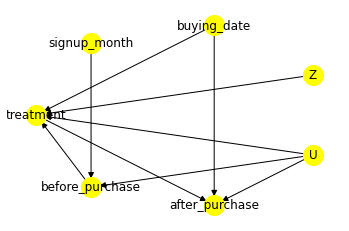

In [14]:
import dowhy
causal_graph = """digraph {
treatment[label="Program Signup in month i"];
before_purchase;
after_purchase;
Z->treatment;
U[label="Unobserved Confounders"]; 
before_purchase -> treatment;
treatment->after_purchase;
buying_date->after_purchase; signup_month->before_purchase;
buying_date->treatment;
U->treatment; U->before_purchase; U->after_purchase;
}"""

# Post-process the data based on the graph and the month of the treatment (signup)
# For each customer, determine their average monthly spend before and after month i

def date_to_int(d):
    return 10000*d.year + 100*d.month + d.day
df = tmp[["customer_id", "buying_date", "treatment", "before_purchase", "after_purchase"]].copy()

df["buying_date"] = [date_to_int(d) if t else 0 for d,t in zip(df["buying_date"],df["treatment"])]

model = dowhy.CausalModel(data=df,
                     graph=causal_graph.replace("\n", " "),
                     treatment="treatment",
                     outcome="after_purchase")
model.view_model()
from IPython.display import Image, display
df

More generally, we can include any activity data for the customer in the above graph. All prior- and post-activity data will occupy the same place (and have the same edges) as the Amount spent node (prior and post respectively). 

## II. Identifying the causal effect
For the sake of this example, let us assume that unobserved confounding does not play a big part. 

In [15]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                               
────────────(Expectation(after_purchase|buying_date,before_purchase))
d[treatment]                                                         
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→after_purchase then P(after_purchase|treatment,buying_date,before_purchase,U) = P(after_purchase|treatment,buying_date,before_purchase)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(after_purchase, [Z])*Derivative([treatment], [Z])**(-1))
Estimand assumption 1, As-if-random: If U→→after_purchase then ¬(U →→{Z})
Estimand assumption 2, Exclusion: If we remove {Z}→{treatment}, then ¬({Z}→after_purchase)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Based on the graph, DoWhy determines that the signup month and amount spent in the pre-treatment months (`buying date`, `before_purchase`) needs to be conditioned on.

## III. Estimating the effect
We now estimate the effect based on the backdoor estimand, setting the target units to "att".

In [16]:
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor1.propensity_score_matching",
                                target_units="att")
print(estimate)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: after_purchase~treatment+buying_date+before_purchase
Target units: att

## Estimate
Mean value: 0.9144660435755866



## IV. Refuting the estimate
We refute the estimate using the placebo treatment refuter. This refuter substitutes the treatment by an independent random variable and checks whether our estimate now goes to zero (it should!).

In [17]:
refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                     placebo_type="permute", num_simulations=2)
print(refutation)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Use a Placebo Treatment
Estimated effect:0.9144660435755866
New effect:0.033379308505617426
p value:1.8288191081093808e-09

